<a href="https://colab.research.google.com/github/mpasha7/VK_Data_Analysis/blob/main/API_VK_min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install vk

In [ ]:
import vk
from vk.exceptions import VkAPIError
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import time
from pprint import pprint
import random
import itertools
import sys
from datetime import datetime

In [ ]:
## Подключение к API VK
with open(f'config.yaml', 'r') as f:
  config = yaml.safe_load(f)

token = config['token']
version = config['version']
api = vk.API(access_token=token, v=version)

In [ ]:
## Функция для получения подписчиков сообщества
def fetch_members(group_id: str) -> list:
  try:
    members = api.groups.getMembers(group_id=group_id,
                                  fields='sex,bdate,country,city,occupation,universities',
                                  lang='ru')
  except:
    return []

  offset = 1000
  members_count = members['count']
  print(f"В группе {group_id} {members_count} подписчиков")
  members = members['items']

  while offset < members_count:
    members.extend(
        api.groups.getMembers(group_id=group_id,
                         fields='activity,sex,bdate',
                         count=1000,
                         offset=offset,
                         lang='ru')['items'])
    offset += 1000
    time.sleep(0.34)

  return members

In [ ]:
## Функция для ввода id/screen_name сообщества
def get_members(num):
  while True:
    group_id = input(f'Id или короткое имя {num} группы: ')
    members = fetch_members(group_id)
    if len(members) > 0:
      return members
    else:
      print('Нет доступа к подписчикам этой группы!')

In [ ]:
def get_members_groups(members):
  ## Список ID всех подписчиков с открытым аккаунтом
  ids_members = [
      members[i]['id'] for i in range(len(members))
      if members[i]['is_closed'] is False
  ]
  print(f"В группе {len(ids_members)} подписчиков c открытым аккаунтом")

  members_groups = {}

  while len(members_groups) < 100:
    sample_ids_members = random.sample(ids_members, 100 - len(members_groups))
    members_groups_part = {}
    drop_users = []
    error_count = 0

    for i in tqdm_notebook(sample_ids_members):
      try:
        members_groups_part[i] = api.users.getSubscriptions(user_id=i)['groups']['items']
        time.sleep(0.34)
      except VkAPIError as e:
        drop_users.append(i)
        error_count += 1
        print(f'Error {error_count}:', e.message)

    members_groups = {k: v for k, v in members_groups_part.items() if k not in drop_users}
    print(f"Забаненных пользователей: {len(drop_users)}")

  print(f"Получено {len(members_groups)} пользователей c их списками групп")
  return members_groups

In [ ]:
## ПЕРВАЯ ГРУППА
members1 = get_members(1)                      ## Все пользователи
members1_groups = get_members_groups(members1) ## Выборка 1000 пользователей со списками их групп

Id или короткое имя 1 группы: python_of
В группе python_of 8299 подписчиков
В группе 5328 подписчиков c открытым аккаунтом


<ipython-input-6-c5a9cc208cc9>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(sample_ids_members):


  0%|          | 0/100 [00:00<?, ?it/s]

Забаненных пользователей: 0
Получено 100 пользователей c их списками групп


In [ ]:
## ВТОРАЯ ГРУППА
members2 = get_members(2)                      ## Все пользователи
members2_groups = get_members_groups(members2) ## Выборка 1000 пользователей со списками их групп

Id или короткое имя 2 группы: bookjava
В группе bookjava 8714 подписчиков
В группе 5324 подписчиков c открытым аккаунтом


<ipython-input-6-c5a9cc208cc9>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(sample_ids_members):


  0%|          | 0/100 [00:00<?, ?it/s]

Забаненных пользователей: 0
Получено 100 пользователей c их списками групп


In [ ]:
## Распределение количества пользователей по месяцам рождения и возрасту
## Для выборки пользователей из 5000 (минус брак)
def get_counters(members):
  ## Пользователи с датой рождения
  members_with_bdate = list(
      filter(lambda  x: x.get('bdate'), members)
  )
  print(f'{len(members_with_bdate)} пользователей с датой рождения. ', end='')
  ## Выборка из 5000 пользователей с датой рождения
  members_with_bdate = random.sample(members_with_bdate, 5000)

  MONTHS_MAP = {1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель', 5: 'Май', 6: 'Июнь',
      7: 'Июль', 8: 'Август', 9: 'Сентябрь', 10: 'Октябрь', 11: 'Ноябрь', 12: 'Декабрь'
  }
  months_counter = {'Январь': 0, 'Февраль': 0, 'Март': 0, 'Апрель': 0, 'Май': 0,
      'Июнь': 0, 'Июль': 0, 'Август': 0, 'Сентябрь': 0, 'Октябрь': 0, 'Ноябрь': 0, 'Декабрь': 0
  }
  ages_counter = {}

  ## Собираем месяца рождения
  for m in members_with_bdate:
    try:
      dt = datetime.strptime(m['bdate'], '%d.%m.%Y')
      age = (datetime.now().year - dt.year) // 5 * 5
      if age in ages_counter:
        ages_counter[age] += 1
      else:
        ages_counter[age] = 1
    except:
      try:
        dt = datetime.strptime(m['bdate'], '%d.%m')
      except:
        continue

    month = MONTHS_MAP[dt.month]
    months_counter[month] += 1

  print(f'Обработано: {sum(months_counter.values())}')
  return {'months': months_counter, 'ages': ages_counter}

5895 пользователей с датой рождения. Обработано: 4999
6296 пользователей с датой рождения. Обработано: 4996


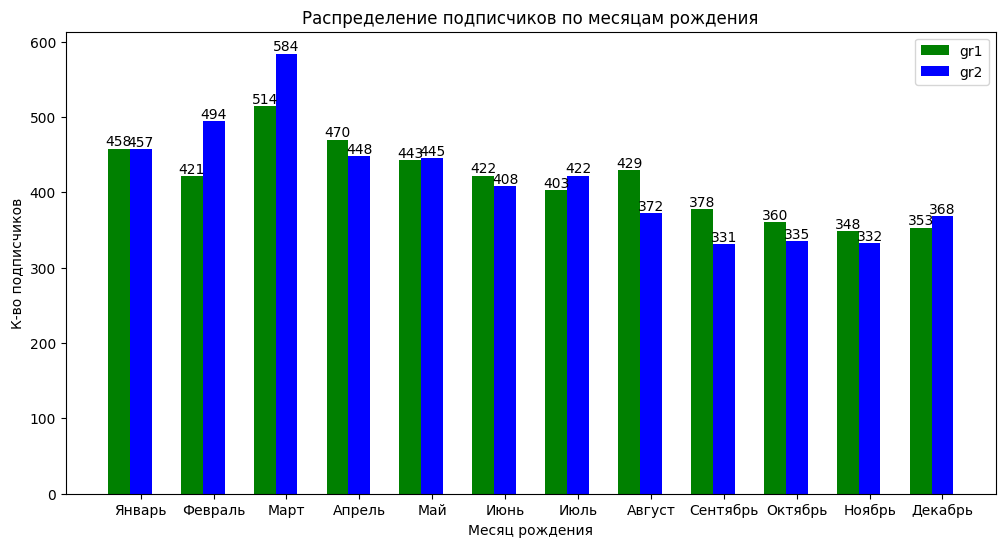

In [ ]:
## Визуализация по месяцам
counters1 = get_counters(members1)
counters2 = get_counters(members2)
months_counter1 = counters1['months']
months_counter2 = counters2['months']

fig, ax = plt.subplots(figsize=(12, 6))
plt.xlabel('Месяц рождения')
plt.ylabel('К-во подписчиков')
names = list(months_counter1.keys())
values1 = list(months_counter1.values())
values2 = list(months_counter2.values())
x = np.arange(len(names))
w = 0.3
bar_1 = ax.bar(x - w/2, values1, w, tick_label=names, label='gr1', color='green')
bar_2 = ax.bar(x + w/2, values2, w, tick_label=names, label='gr2', color='blue')
ax.bar_label(bar_1)
ax.bar_label(bar_2)

ax.set_title('Распределение подписчиков по месяцам рождения')
ax.legend()
plt.show()

In [ ]:
## Функция для выравнивания словарей по ключам
def leveling_dicts(dict1, dict2):
  for k, v in dict1.items():
    if k not in dict2:
      dict2[k] = 0
  for k, v in dict2.items():
    if k not in dict1:
      dict1[k] = 0

  return dict1, dict2

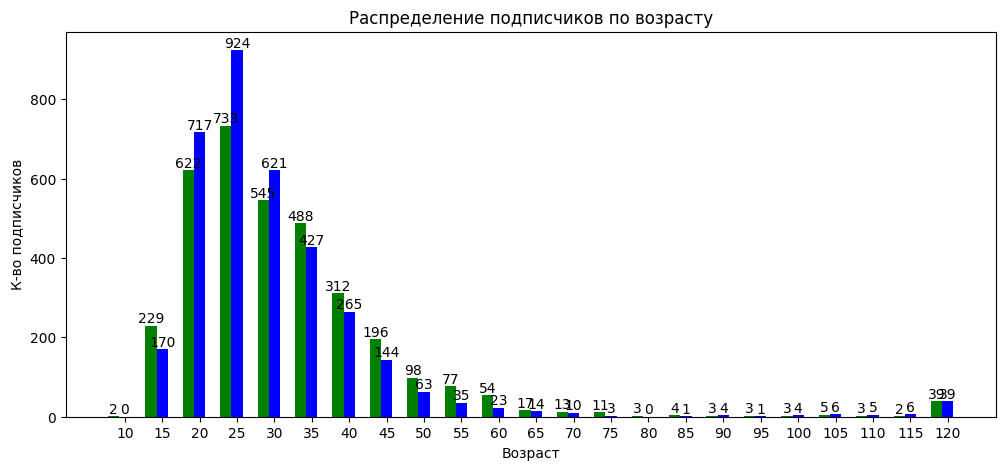

In [ ]:
## Визуализация по возрасту
ages_counter1 = counters1['ages']
ages_counter2 = counters2['ages']
ages_counter1, ages_counter2 = leveling_dicts(ages_counter1, ages_counter2)
## Сортировка
ages_list1 = sorted(ages_counter1.items(), key=lambda x: x[0])
ages_list2 = sorted(ages_counter2.items(), key=lambda x: x[0])

fig, ax = plt.subplots(figsize=(12, 5))
plt.xlabel('Возраст')
plt.ylabel('К-во подписчиков')
names = [t[0] for t in ages_list1]
values1 = [t[1] for t in ages_list1]
values2 = [t[1] for t in ages_list2]
x = np.arange(len(names))
w = 0.3
bar_1 = ax.bar(x - w/2, values1, w, tick_label=names, label='gr1', color='green')
bar_2 = ax.bar(x + w/2, values2, w, tick_label=names, label='gr2', color='blue')
ax.bar_label(bar_1)
ax.bar_label(bar_2)

ax.set_title('Распределение подписчиков по возрасту')
plt.show()

In [ ]:
## Странности с датой рождения
for m in members1:
  try:
    dt = datetime.strptime(m['bdate'], '%d.%m.%Y')
    if dt.year < 1930:
      print(dt.year)
  except:
    continue

1902
1901
1902
1901
1920
1917
1903
1920
1917
1901
1902
1908
1902
1915
1902
1901
1902
1928
1906
1926
1918
1901
1922
1902
1902
1901
1901
1901
1901
1902
1901
1901
1902
1901
1911
1901
1912
1920
1901
1902
1915
1924
1901
1902
1917
1901
1917
1914
1901
1902
1911
1901
1902
1901
1905
1901
1925
1903
1902
1902
1901
1901
1903
1901


In [ ]:
## Распределение по полу
def get_genders(members):
  GENDER = {
      1: 'female',
      2: 'male'
  }
  result_gender = {'female': 0, 'male': 0}

  for m in members:
      gender = m.get('sex')
      name_gender = GENDER.get(gender)
      if name_gender:
          result_gender[name_gender] += 1

  return result_gender

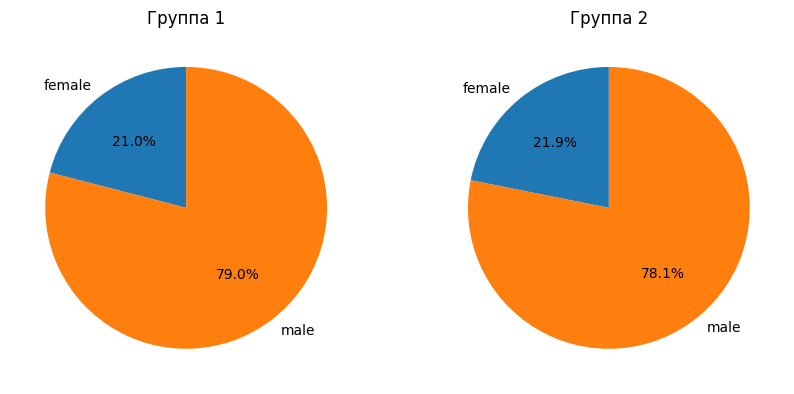

In [ ]:
genders1 = get_genders(members1)
genders2 = get_genders(members2)

plt.rcParams["figure.figsize"] = 10, 6

plt.subplot(1, 2, 1)
plt.title('Группа 1')
plt.pie(genders1.values(), labels=genders1.keys(), startangle=90, autopct='%1.1f%%')

plt.subplot(1, 2, 2)
plt.title('Группа 2')
plt.pie(genders2.values(), labels=genders2.keys(), startangle=90, autopct='%1.1f%%')
plt.show()

In [ ]:
## ПЕРЕСЕЧЕНИЕ
df_members1 = pd.json_normalize(members1)
df_members2 = pd.json_normalize(members2)
intersection = pd.merge(df_members1, df_members2, how='inner', on=['id'])
len(intersection)

1720

In [ ]:
intersection

,id,bdate_x,sex_x,first_name_x,last_name_x,can_access_closed_x,is_closed_x,city.id_x,city.title_x,country.id_x,...,status_audio.url_y,status_audio.stream_duration_y,status_audio.date_y,status_audio.main_artists,status_audio.short_videos_allowed_y,status_audio.stories_allowed_y,status_audio.stories_cover_allowed_y,status_audio.release_audio_id_y,status_audio.genre_id_y,status_audio.content_restricted_y
0,7123,12.6.1985,2,Николай,Булыгин,True,False,177.0,Выборг,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,80829,NaN,2,Vladimir,Zux,True,False,1.0,Москва,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,105307,27.9.1989,2,Иван,Савченко,True,False,80.0,Люберцы,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,105450,NaN,2,Хасан,Садретдинов,False,True,151.0,Уфа,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,119039,NaN,2,Паша,Власов,True,False,2.0,Санкт-Петербург,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,841710513,NaN,2,Автор,Безымянный,False,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1716,842566371,27.3.1997,2,Baglan,Almasbek,True,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1717,843172248,15.9.1996,2,Pablo,Escobar,True,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1718,850651309,21.5,2,Денис,Орлов,True,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## Переставим ключи и значения
## Для каждой группы получим список пользователей
dict_group_members = {}

for key, values in members1_groups.items():
  for value in values:
    dict_group_members.setdefault(value, set()).add(key)

for key, values in members2_groups.items():
  for value in values:
    dict_group_members.setdefault(value, set()).add(key)

print(len(dict_group_members))

## TEST
for k, v in dict_group_members.items():
  if k == 216361171 or k == 210079547:
    print(f'{k} -> {len(v)} подписчиков')

26662
216361171 -> 117 подписчиков
210079547 -> 119 подписчиков


In [ ]:
## Выберем только те группы, где пересечений с начальной группой больше 500
dict_group_members_more = {
    i: dict_group_members[i]
    for i in dict_group_members.keys() if (len(dict_group_members[i])) > 40
}

# del_elems = []
# for i in dict_group_members_more:
#   for j in dict_group_members_more:
#     if len(dict_group_members_more[i] & dict_group_members_more[j]) == 0:
#       del_elems.append(j)

# dict_group_members_more = {k: v for k, v in dict_group_members_more.items() if k not in del_elems}

len(dict_group_members_more.keys())

43

In [ ]:
## Получим названия и топики групп
# from pprint import pprint
name_groups = {}
topic_groups = {}

for key, value in tqdm_notebook(dict_group_members_more.items()):
  info_group = api.groups.getById(group_id=key, fields='activity', lang='ru')[0]
  # pprint(info_group)
  name_groups[key] = info_group['name']
  topic_groups[key] = info_group['activity']
  time.sleep(0.34)

<ipython-input-23-b5a997d096ad>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key, value in tqdm_notebook(dict_group_members_more.items()):


  0%|          | 0/43 [00:00<?, ?it/s]

In [ ]:
## Количество пользователей в каждой группе
members_counts = {
    group: len(dict_group_members_more[group])
    for group in dict_group_members_more
}

In [ ]:
## Словарь с информацией по пересечениям пользователей между сообществами
## Матрица смежности
adjacency_matrix = {}

for i in dict_group_members_more:
  for j in dict_group_members_more:
    if i != j:
      # нормирование
      # if len(dict_group_members_more[i] & dict_group_members_more[j]) != 0:
      adjacency_matrix[i+j] = 1 / (len(dict_group_members_more[i] & dict_group_members_more[j]) + 0.25)

In [ ]:
!pip install netgraph

In [ ]:
import networkx as nx
from netgraph import Graph

In [ ]:
## Неориентированный граф
G = nx.Graph()

for i in dict_group_members_more:
  ## создаем узел - ID сообщества
  G.add_node(i)

  for j in dict_group_members_more:
    ## добавляем ребра - связи между узлами
    if i != j:
      G.add_edge(i, j, weight=adjacency_matrix[i+j])

In [ ]:
## Добавляем атрибуты - имя и топики
nx.set_node_attributes(G, name_groups, 'name')
nx.set_node_attributes(G, topic_groups, 'topic')

In [ ]:
## Получаем тематики канала
node_to_group = nx.get_node_attributes(G, 'topic')

## Количество неповторяющихся топиков
n_topics = len(set(node_to_group.values()))
## Цветовая схема
cmap = sns.color_palette("RdBu_r", n_topics)
## Цвета топиков
group_to_color = {
    key: cmap.as_hex()[num]
    for num, key in enumerate(set(node_to_group.values()))
}
## Сопоставляем цвет-топик-id группы
node_color = {
    group_id: group_to_color[topic] \
    for group_id, topic in node_to_group.items()
}
## Размер узла
node_size = {
    key: value / 30
    for key, value in members_counts.items()
}
## Размер ребра
edge_width = {}
edge_width = {
    key: value / 5
    for key, value in nx.get_edge_attributes(G, 'weight').items()
}
## Названия узлов
node_labels = nx.get_node_attributes(G, 'name')

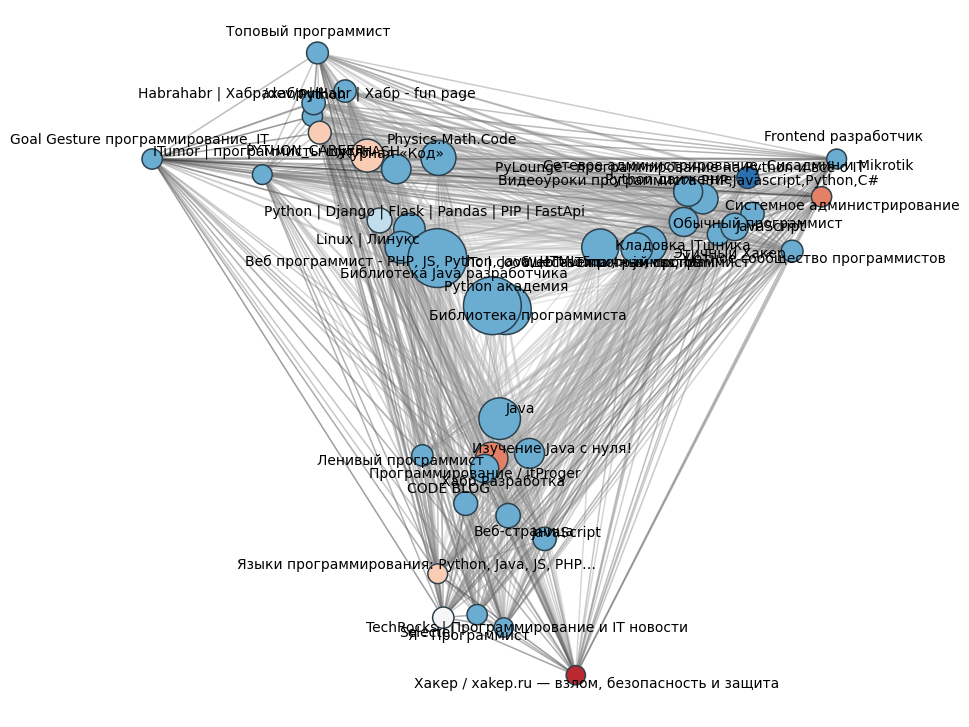

In [ ]:
## Близость групп по пересечению множества подписчиков
fig, ax = plt.subplots(figsize=(10, 10))

Graph(
    G,
    node_size=node_size,
    node_color=node_color,
    node_labels=node_labels,
    node_label_offset=0.03,
    node_edge_width=0.2,
    edge_width=0.2,
    edge_alpha=0.5,
    node_layout='geometric',
    node_layout_kwargs=dict(edge_length=edge_width),
    ax=ax
)
plt.show()

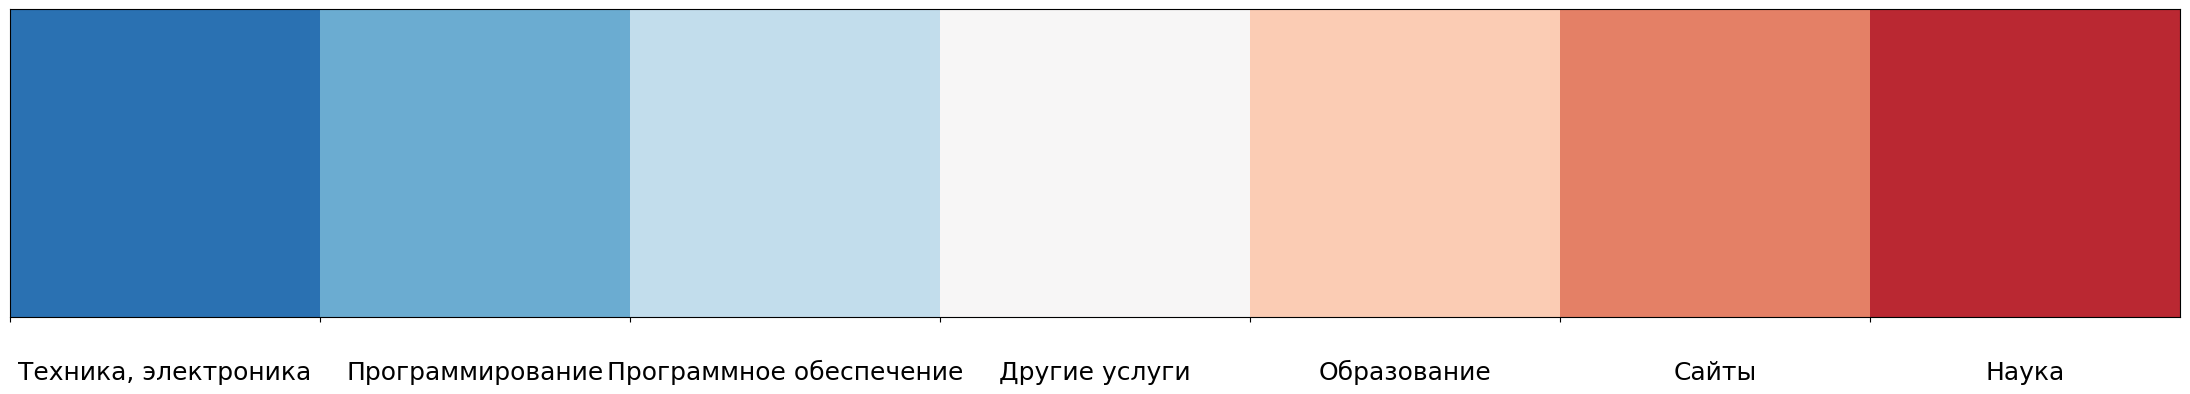

In [ ]:
## Палитра
sns.palplot({value: key for key, value in group_to_color.items()}, size=4)
ax = plt.gca()
for i, name in enumerate(group_to_color):
  ax.text(i, 0.7, name, horizontalalignment='center', size=18, color='black')

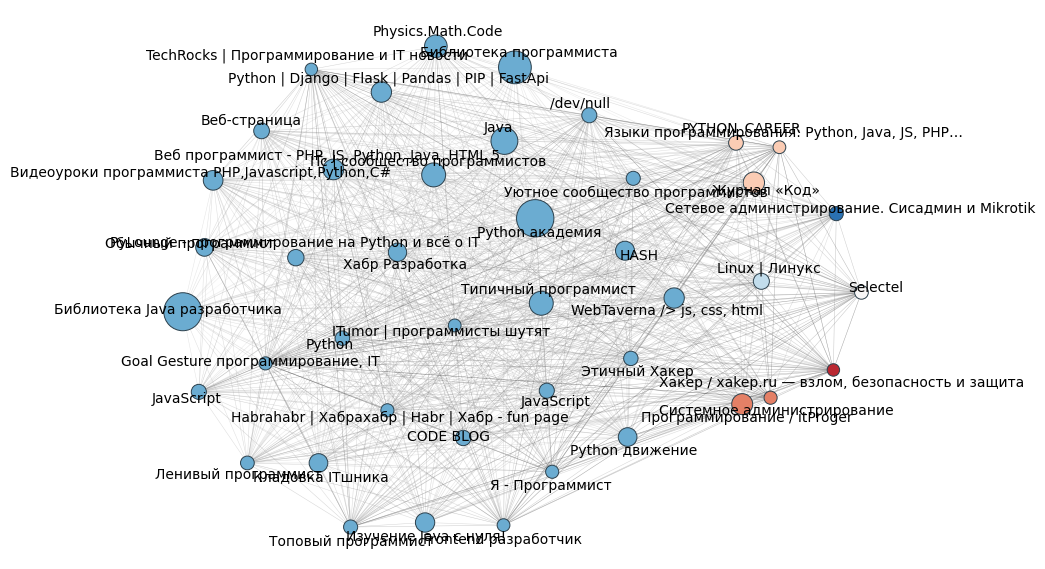

In [ ]:
## Выделенные комьюнити
fig, ax = plt.subplots(figsize=(10, 10))

Graph(
    G,
    node_color=node_color,
    node_edge_width=0.2,
    edge_width=0.1,
    edge_alpha=0.5,
    node_size=node_size,
    node_labels=node_labels,
    node_label_offset=0.03,
    node_layout='community',
    node_layout_kwargs=dict(node_to_community=node_to_group),
    ax=ax
)

/usr/local/lib/python3.10/dist-packages/netgraph/_edge_layout.py:978: RuntimeWarning: invalid value encountered in divide
  displacement = compatibility * delta / distance_squared[..., None]
/usr/local/lib/python3.10/dist-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


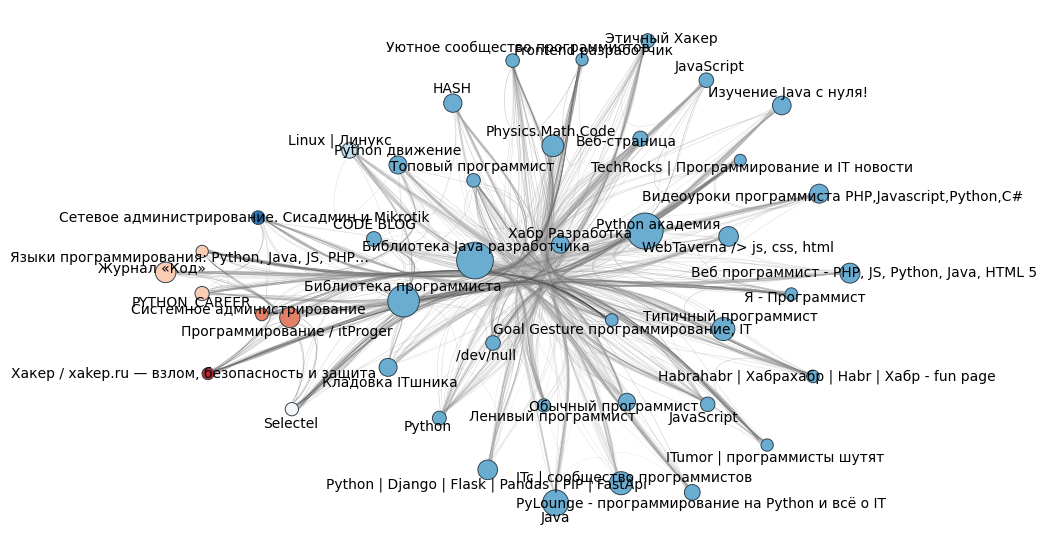

In [ ]:
## Посмотрим на выделенные комьюнити
fig, ax = plt.subplots(figsize=(10, 10))

Graph(
    G,
    node_color=node_color,
    node_edge_width=0.2,
    edge_width=0.1,
    edge_alpha=0.5,
    node_size=node_size,
    node_labels=node_labels,
    node_label_offset=0.03,
    node_layout='community',
    node_layout_kwargs=dict(node_to_community=node_to_group),
    edge_layout='bundled',
    ax=ax
)